<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>




<br>

# <font color="#76b900" style="text-align:center;">**Notebook 6.4:** 語意護欄(Semantic Guardrailing)</font>


這個 notebook 是 **Notebook 6: 內嵌模型(Embedding Models)與語意分析推理(Semantic Reasoning)** 的直接延續。然而，由於其長度和偏離主要主題，已將其分割為獨立的 notebook。


<br>

### **環境設置：**

In [1]:
## Necessary for Colab, not necessary for course environment
# %pip install -qq langchain langchain-nvidia-ai-endpoints gradio

# import os
# os.environ["NVIDIA_API_KEY"] = "nvapi-..."

## If you encounter a typing-extensions issue, restart your runtime and try again
# from langchain_nvidia_ai_endpoints import ChatNVIDIA
# ChatNVIDIA.get_available_models()

from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

# NVIDIAEmbeddings.get_available_models()
embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

# ChatNVIDIA.get_available_models()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1")

NVIDIAEmbeddings.get_available_models()

/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:237: UserWarning: Default model is set as: 01-ai/yi-large. 
Set model using model parameter. 
To get available models use available_models property.
  warnings.warn(


[Model(id='01-ai/yi-large', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-yi-large'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='abacusai/dracarys-llama-3.1-70b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='ai21labs/jamba-1.5-large-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='ai21labs/jamba-1.5-mini-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='aisingapore/sea-lion-7b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-sea-lion-7b-instruct'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='baichuan-inc/baichu

<br>

## **第四部分：[進階練習]** 內嵌(Embedding)用於語意護欄(Guardrails)


在下一個 notebook 中，我們將使用更高階的實用工具來採用我們的內嵌模型(Embedding Model)並在幕後使用它。在此之前，有幾個重要概念我們可以在原始方法仍然新鮮時探索！

具體來說，我們可以將其用作正式環境(Production)模型關鍵組件的骨幹：**語意護欄(semantic guardrailing)**。具體來說，我們可以使用內嵌(Embedding)來過濾掉對我們的聊天機器人來說不太可能有用（或積極有害）的訊息！

<br>

### **相較於自回歸(Autoregressing)引導過濾(Autoregression-Guided Filtering)的優勢**


您可能還記得從之前的 notebook 中，我們可以使用我們的 LLM 來促進複雜的內部分析推理(Reasoning)，那麼為什麼不用它來過濾呢？具體來說，您可能會想到要求 LLM 判斷問題，然後使用 `RunnableBranch` 進行分支(Branch)。事實上，您絕對可以這樣做，但該系統有一些需要進一步考慮的明顯優缺點：

> **優點：** 透過提示(Prompt)工程您的內部系統來限制對話進展相對快速且容易。您甚至可以開發一個例程，該例程採用好問題和壞問題的範例，並生成一個一致返回「好」或「壞」有限狀態的單一緊湊提示(Prompt)。
>
> **缺點：** 使用自回歸(Autoregressing)路由通常會帶來一些可能不可接受的延遲或資源開銷。例如，您可能希望在幕後整合一個語意護欄(Guardrails)機制，該機制既防止有害輸出，又將有問題的輸入(Intake)引導向安全和可預測的方向。您的自回歸(Autoregressing)選項如下：
>
> -   **您可以使用相對較小的指令調整模型作為零樣本(Zero-Shot)分類器，並希望其效能保持一致** 為了促進這一點，您可能還需要將輸入(Intake)轉換為您的模型最佳執行的規範（標準）形式。
>
> -   **您也可以微調一個小型自回歸(Autoregressing) LLM 來很好地適用於您的任務。** 您必須進行一些合成資料策展，並可能需要為一次性微調成本花費一些額外的計算預算，但這至少應該允許較小的模型預設模仿較大提示(Prompt)工程模型的效能。
>

雖然這些選項很好，但這個特定的使用案例可以很好地透過一個不錯的內嵌模型(Embedding Model)、一些資料整理(curation)和對基本深度學習想法的重新思考來處理。

**具體來說，我們可以使用內嵌模型(Embedding Model)作為語言骨幹，然後可以在其上訓練分類器(Classifier)來預測機率**。我們將探索這個想法並在出現新挑戰時解決它們。



<br>

#### **任務 1：生成合成資料。**


要開始製作語意護欄(Guardrails)，我們顯然需要從一些目標開始。

-   **假設：** 假設我們想製作一個 NVIDIA 聊天機器人，它應該主要回應討論技術和公司相關細節！您可能認為這是一個相當狹隘的聊天機器人定義，有一些明顯的陷阱，您完全正確！儘管如此，這是一個有趣的起點，產生的產物在概念上很容易擴展到更真實的問題！

-   **行動規劃開發方向(plan a course)** ：為了幫助識別我們正在處理什麼樣的資料(Entries)，生成一些代表性輸入(Intake)來定義什麼是*好*和*差*的回應輸入(Intake)是個好主意。然後我們可以看看我們的內嵌模型(Embedding Model)如何處理這些範例並相應地設計解決方案。

不幸的是，我們沒有任何真實資料，所以看起來合成生成必須做！作為練習，生成一些代表性的好和差範例，您可以用於您的之後護欄(Guardrails)的擬合(fitting)。

In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
from operator import itemgetter

## Useful method for mistral, which is currently tuned to output numbered outputs
def EnumParser(*idxs):
    '''Method that pulls out values from a mistral model that outputs numbered entries'''
    idxs = idxs or [slice(0, None, 1)]
    entry_parser = lambda v: v if ('. ' not in v) else v[v.index('. ')+2:]
    out_lambda = lambda x: [entry_parser(v).strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: itemgetter(*idxs)(out_lambda(x)))

instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1") | EnumParser()

from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

gen_prompt = {'input' : lambda x:x} | ChatPromptTemplate.from_template(
    "Please generate 20 representative conversations that would be {input}."
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure all of your outputs are numbered."
    " Example Response: 1. <question>\n2. <question>\n3. <question>\n..."
)

## Some that directly reference NVIDIA
responses_1 = (gen_prompt | instruct_llm).invoke(
    " reasonable for an NVIDIA document chatbot to be able to answer."
    " Vary the context to technology, research, deep learning, language modeling, gaming, etc."
)
print("Reasonable NVIDIA Responses:", *responses_1, "", sep="\n")

## And some that do not
responses_2 = (gen_prompt | instruct_llm).invoke(
    " be reasonable for a tech document chatbot to be able to answer. Make sure to vary"
    " the context to technology, research, gaming, language modeling, graphics, etc."
)
print("Reasonable non-NVIDIA Responses:", *responses_2, "", sep="\n")

## Feel free to try your own generations instead
responses_3 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an NVIDIA document chatbot to answer,"
    " as it is irrelevant and will not be useful to answer (though not inherently harmful)."
)
print("Irrelevant Responses:", *responses_3, "", sep="\n")

responses_4 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for a chatbot (NVIDIA's, AMD's, Intels, or Generally) to answer,"
    " as an automated response will either be overly insensitive or offensive."
)
print("Harmful non-NVIDIA", *responses_4, "", sep="\n")

## Feel free to try your own generations instead

good_responses = responses_1 + responses_2
poor_responses = responses_3 + responses_4

Reasonable NVIDIA Responses:
"Can you tell me about the latest advancements in deep learning technology at NVIDIA?"
"What kind of research is NVIDIA currently conducting in the field of autonomous vehicles?"
"How does NVIDIA's language modeling technology compare to other companies in the industry?"
"Can you provide an overview of NVIDIA's role in the development of artificial intelligence?"
"What are some examples of how NVIDIA's graphics technology is being used in the gaming industry?"
"Can you explain how NVIDIA's deep learning platforms are being used in healthcare?"
"What are the benefits of using NVIDIA's DGX systems for data science research?"
"Can you tell me about any partnerships or collaborations NVIDIA has with other tech companies?"
"How is NVIDIA's technology being used in the field of robotics and automation?"
"Can you explain the role of NVIDIA's GPUs in the development of virtual reality?"
"What are some of the real-world applications of NVIDIA's deep learning technol

<br>

### **任務 2：生成更多內嵌(Embedding)（並且更快）**


一旦您對合成資料滿意，就是時候將它們全部內嵌(Embedding)到語意向量中了。我們之前使用同步 `embed_query` 和 `embed_documents` 方法內嵌(Embedding)文件的技術對於較小或更即時的情況是足夠的。然而，當我們需要一次內嵌(Embedding)大量內嵌(Embedding)時，這會產生不必要的瓶頸。

在本節中，我們將使用**非同步技術**來允許多個內嵌(Embedding)操作同時發生！值得注意的是，這是一種更中級的技術，經常在背景自動利用。**它*不是*無限並行處理(infinite concurrency)的來源**，在手動將其整合到更大的部署架構(Deployment)之前應該更深入地研究。

<br>

#### **計時解決方案**


`%%time` 實用工具不適用於 notebook 中的非同步解決方案，所以以下是一個基於範圍的計時實用工具，應該會讓我們的生活更輕鬆。下面，我們定義它並測試內嵌(Embedding)前 10 個文件需要多長時間：

In [4]:
import time
import numpy as np

class Timer():
    '''Useful timing utilities (%%time is great, but doesn't work for async)'''
    def __enter__(self):
      self.start = time.perf_counter()

    def __exit__(self, *args, **kwargs):
        elapsed = time.perf_counter() - self.start
        print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")

with Timer():
    good_embeds = [embedder.embed_query(x) for x in good_responses[:10]]

print("Shape:", np.array(good_embeds).shape)

Executed in 3.85 seconds.
Shape: (10, 4096)


<br>

#### **朝向非同步內嵌(Asynchronous Embedding)**


注意這個內嵌(Embedding)查詢需要很長時間來執行。如果我們有對內嵌模型(Embedding Model)的原始存取權限，我們就能夠透過批次處理我們的回應來進行一些簡單的加速。然而，雲端中的查詢路由器(Router)已經自動執行此操作，並選擇將使用者限制為單一查詢以確保公平性和同質性。

換句話說，這不是服務無法更快地內嵌(Embedding)，而是我們的程式碼正在等待每個 `embed_query` 命令的每個單一內嵌(Embedding)*按順序*發生。

當我們需要一次內嵌(Embedding)很多文件時，通常更好的想法是一次*非同步*提交所有請求並等待結果進來。如果正確實作，這將大大加快您在本地端的內嵌(Embedding)過程，同時對 LLM 服務只有邊際影響（假設查詢路由器(Router)強制執行[**即時動態(in-flight)批次處理**](https://github.com/NVIDIA/TensorRT-LLM/blob/b777bd64750abf30ca7eda48e8b6ba3c5174aafd/docs/source/advanced/gpt-attention.md?plain=1#L137)，其中多個請求被堆疊並作為批次透過神經網路餵入）。

我們可以測試 LangChain 標準的 `aembed_<...>` 選項來生成一些 **協程(Coroutines)** ，這些是用於 **並行(concurrent)** 執行的過程：

In [5]:
with Timer():
    good_embed_gens = [embedder.aembed_query(query) for query in good_responses[10:20]]
print(good_embed_gens[0])

## NOTE: When you define coroutines, you will want to either execute them or close them.
##  Destroying an open coroutine object by overriding will throw a warning.
for gen in good_embed_gens:
    gen.close()

Executed in 0.00 seconds.
<coroutine object Embeddings.aembed_query at 0x7f2f69323840>




它們可以使用 `await` 關鍵字單獨等待，或使用類似於 [`asyncio.gather`](https://docs.python.org/3/library/asyncio-task.html#id8) 的東西並行(concurrently)執行。使用後一個選項，asyncio 將同時執行所有這些協程，當最後一個完成時，回應將被整合(Aggregate)或**收集(gathered)**。

In [6]:
import asyncio

with Timer():
    tasks = [embedder.aembed_query(query) for query in good_responses[10:20]]
    good_embeds2 = await asyncio.gather(*tasks)

print("Shape:", np.array(good_embeds2).shape)

Executed in 1.78 seconds.
Shape: (10, 4096)


而之前的非非同步版本顯示了*按順序*內嵌(Embedding)所有這些回應需要多長時間，這個新時間反映了過程 *並行(concurrently)* 需要多長時間，大致與最長的單一內嵌(Embedding)請求相關。


#### **限制並行(concurrently)性**


雖然這個系統比我們的同步版本快得多，但重要的是要注意並發性不能無限堆疊！隨著足夠多的任務並發運行，事情可能會中斷，服務可能會限制您，資源可能會耗盡。在實踐中，使用一些控制結構來限制最大並發性是個好主意，例如使用 asyncio **信號量(semaphore)** 結構（一個限制最大並發行的非同步原語(async primitive)）：

In [7]:
import asyncio
from collections import abc
from typing import Callable
from functools import partial

async def embed_with_semaphore(
    text : str,
    embed_fn : Callable,
    semaphore : asyncio.Semaphore
) -> abc.Coroutine:
    async with semaphore:
        return await embed_fn(text)

## Making new embed method to limiting maximum concurrency
embed = partial(
    embed_with_semaphore,
    embed_fn = embedder.aembed_query,
    semaphore = asyncio.Semaphore(value=10)  ## <- feel free to play with value
)

## This is once again a coroutine constructor, so should take marginal time
tasks = [embed(query) for query in good_responses[20:30]]

with Timer():
    good_embeds_3 = await asyncio.gather(*tasks)

Executed in 1.65 seconds.


<br>

#### **[練習] 內嵌(Embedding)其他的回應**


現在您已經看到如何執行此過程，透過使用這些新技術內嵌(Embedding)其餘文件來結束。嘗試將並行性限制為合理的數量（如果失敗，您會知道的）並看看您是否可以使其順暢的快速執行。

在我們對系統當前狀態的測試中，我們發現 10 是一個甜蜜點，之後我們的並發行好處開始減少。在選擇您的值時請記住這一點。

In [8]:
####################################################################################
## BEGIN TODO

## Note, we found marginal benefit after value=10 in our tests...
with Timer():
    good_tasks = [embed(query) for query in good_responses]
    poor_tasks = [embed(query) for query in poor_responses]
    all_tasks = good_tasks + poor_tasks
    embeds = await asyncio.gather(*all_tasks)
    good_embeds = embeds[:len(good_tasks)]
    poor_embeds = embeds[len(good_tasks):]

print("Good Embeds Shape:", np.array(good_embeds).shape)
print("Poor Embeds Shape:", np.array(poor_embeds).shape)

## END TODO
####################################################################################

Executed in 11.37 seconds.
Good Embeds Shape: (40, 4096)
Poor Embeds Shape: (40, 4096)


### **任務 3：確認語意密度**


我們生成這些內嵌(Embedding)的原因取決於它們對語意過濾有用的假設。為了幫助確認這一點，我們可以使用一些經典的機器學習方法，如[**主成分分析 (PCA)**](https://en.wikipedia.org/wiki/Principal_component_analysis) 或 [**t 分布隨機鄰居內嵌(t-distributed stochastic neighbor embedding, t-SNE)**](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) 進行降維。這些技術本質上將高維資料轉換為低維表示，同時嘗試保持重要的統計屬性完整。它們非常適合視覺化語意叢集式(Clustering)，所以讓我們看看當我們在我們的內嵌(Embedding)上執行它時會發生什麼：

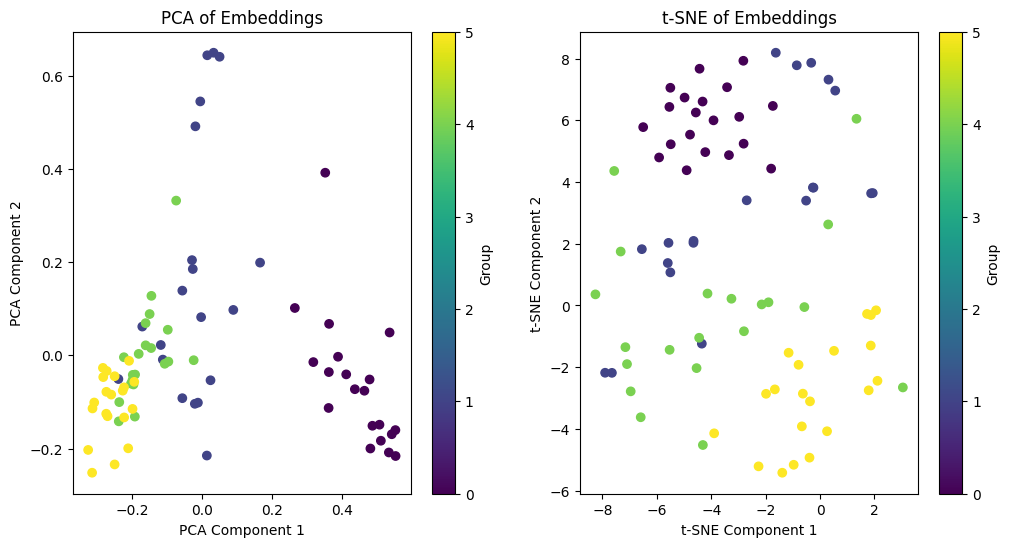

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Combine all groups into a single dataset
embeddings = np.vstack([good_embeds, poor_embeds])

# Labels for each point
labels = np.array([0]*20 + [1]*20 + [4]*20 + [5]*20)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()

<br>


如果一切都正確，您應該看到一些相當明顯的叢集式(Clustering)回應。在實踐中，您肯定會想要考慮更多範例並進行一些詳盡的檢查，但這對我們來說是足夠的。

<br>


### **任務 4：** 訓練我們的分類器(Classifier)


從這些內嵌(Embedding)中，我們可以訓練一個簡單的分類器(Classifier)來預測內嵌(Embedding)是好還是壞！

儘管我們有 CPU 限制的環境假設，一個簡單的兩層網路可能足以應付這個使用案例，因為我們正在利用強大的內嵌模型(Embedding Model)骨幹。請記住，即使這個過程需要更長時間或需要更多資源，它仍然很容易證明，因為我們接受一次性成本來訓練可重複使用的組件。對終端使用者真正有影響的唯一降速是推論(Inference)速度（這將非常快）！


#### **訓練深度分類器(Classifier)**


如果您有複雜的決策邊界(decision boundary)並且對深度學習感到熟悉，您可能傾向於使用像 [Keras](https://keras.io/keras_3/) 這樣的框架製作分類器(Classifier)。我們可以嘗試以下訓練例程，注意其與 Keras 2 或 Keras 3 的相容性。如果您不熟悉這個框架，我們建議查看相應的指南：

-   **[Keras 3.0 函式(function) API](https://keras.io/guides/functional_api/)**

-   **[Keras 3.0 Sequential Model](https://keras.io/guides/sequential_model/)**

In [10]:
with Timer():
    print("Importing Keras for the first time")
    import keras
    from keras import layers

def train_model_neural_network(class0, class1):
    ## Classic deep learning training loop. If using this, train it to convergence
    model = keras.Sequential([
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation='sigmoid'),
    ])
    ## Since this network is so shallow and the embedding backbone is "kept frozen"
    ##  a high learning rate should not overfit and will actually converge very quickly.
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 1),
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)],
        metrics = [keras.metrics.BinaryAccuracy()],
    )
    ## Since this uses stochastic gradient descent, we'll need to repeat this process

    reps_per_batch = 64*5  ## <- repeat the dataset, effectively increasing "epochs" without printing too much
    epochs = 2             ## <- one epoch should actually be sufficient; 2 to print out an updated training loss
    x = np.array((class0 + class1) * reps_per_batch)
    y = np.array(([0]*len(class0) + [1]*len(class1)) * reps_per_batch)
    model.fit(x, y, epochs=epochs, batch_size=64, validation_split=.5)
    return model

with Timer():
    model1 = train_model_neural_network(poor_embeds, good_embeds)

Importing Keras for the first time


2025-06-18 08:18:57.358953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Executed in 14.15 seconds.
Epoch 1/2


2025-06-18 08:19:17.417810: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.


196/200 [============================>.] - ETA: 0s - loss: 0.3227 - binary_accuracy: 0.9892

2025-06-18 08:19:20.546599: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.


200/200 [==============================] - 4s 15ms/step - loss: 0.3162 - binary_accuracy: 0.9894 - val_loss: 3.4533e-10 - val_binary_accuracy: 1.0000
Epoch 2/2
200/200 [==============================] - 2s 11ms/step - loss: 3.3528e-10 - binary_accuracy: 1.0000 - val_loss: 3.2450e-10 - val_binary_accuracy: 1.0000
Executed in 15.26 seconds.


#### 擬合(Fitting)更簡單的分類器(Classifier)


由於內嵌模型(Embedding Model)在其回應中已經有如此多的語意密度，這是您可以有效地使用封閉式最佳化(closed-form optimization )解決方案的地方之一（即，不需要訓練，因為我們可以用固定表達式(fixed expression)計算數學最優）。

下面是一個甚至更快的分類器頭(classification head)擬合範例，使用標準邏輯回歸(logistic regression)。您會注意到其準確性可能不如預期，但只要您的資料整理得很好(well-curated)，它仍然應該運作良好。確保您的訓練和驗證準確性都接近 100%，以確認過度擬合不太可能。

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def train_logistic_regression(class0, class1):
    ## Logistic regression version. Optimized mathematically using closed-form algorithm.
    x = class0 + class1
    y = [0] * len(class0) + [1] * len(class1)
    x0, x1, y0, y1 = train_test_split(x, y, test_size=0.5, random_state=42)
    model = LogisticRegression()
    model.fit(x0, y0)
    print(np.array(x0).shape)
    print("Training Results:", model.score(x0, y0))
    print("Testing Results:", model.score(x1, y1))
    return model

with Timer():
    model2 = train_logistic_regression(poor_embeds, good_embeds)

(40, 4096)
Training Results: 0.975
Testing Results: 0.95
Executed in 0.23 seconds.


<br>


### **任務 5：[練習]** 整合到我們的聊天機器人中


現在我們有一個可以附加到我們內嵌模型(Embedding Model)的分類器(Classifier)，我們可以將其用作我們事件迴圈(event loop)的一部分，大致具有單一內嵌模型(Embedding Model)查詢的延遲。

我們可以設置系統完全拒絕不好的問題( poor questions)，但這將大大損害使用者體驗。***也許更好的策略可能是使用分類來修改系統提示(Prompt)以阻止模型回答使用者的問題。***

#### **任務：** 適當地實作 `score_response` 方法來過濾資料。

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

import gradio as gr

embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")
chat_llm = ChatNVIDIA(model="meta/llama3-70b-instruct") | StrOutputParser()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1") | StrOutputParser()

response_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

def RPrint(preface=""):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))
## "Help them out" system message
good_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Please help them with their question if it is ethical and relevant."
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Their question has been analyzed and labeled as 'probably not useful to answer as an NVIDIA Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)

########################################################################################
## BEGIN TODO

def score_response(query):
    ## TODO: embed the query and pass the embedding into your classifier
    ## TODO: return the score for the response
    return False

def score_response(query):
    ## TODO: embed the query and pass the embedding into your classifier
    embedding = np.array([embedder.embed_query(query)])
    ## TODO: return the score for the response
    return model1(embedding)

## END TODO
########################################################################################

chat_chain = (
    { 'input'  : (lambda x:x), 'score' : score_response }
    | RPrint()
    | RunnableAssign(dict(
        system = RunnableBranch(
            ## Switch statement syntax. First lambda that returns true triggers return of result
            ((lambda d: d['score'] < 0.5), RunnableLambda(lambda x: poor_sys_msg)),
            ## ... (more branches can also be specified)
            ## Default branch. Will run if none of the others do
            RunnableLambda(lambda x: good_sys_msg)
        )
    )) | response_prompt | chat_llm
)

########################################################################################

def chat_gen(message, history, return_buffer=True):
    buffer = ""
    for token in chat_chain.stream(message):
        buffer += token
        yield buffer if return_buffer else token

def queue_fake_streaming_gradio(chat_stream, history = [], max_questions=8):

    ## Mimic of the gradio initialization routine, where a set of starter messages can be printed off
    for human_msg, agent_msg in history:
        if human_msg: print("\n[ Human ]:", human_msg)
        if agent_msg: print("\n[ Agent ]:", agent_msg)

    ## Mimic of the gradio loop with an initial message from the agent.
    for _ in range(max_questions):
        message = input("\n[ Human ]: ")
        print("\n[ Agent ]: ")
        history_entry = [message, ""]
        for token in chat_stream(message, history, return_buffer=False):
            print(token, end='')
            history_entry[1] += token
        history += [history_entry]
        print("\n")

## history is of format [[User response 0, Bot response 0], ...]
history = [[None, "Hello! I'm your NVIDIA chat agent! Let me answer some questions!"]]

## Simulating the queueing of a streaming gradio interface, using python input
queue_fake_streaming_gradio(
    chat_stream = chat_gen,
    history = history
)


[ Agent ]: Hello! I'm your NVIDIA chat agent! Let me answer some questions!



[ Human ]:  How to steal at store ? 



[ Agent ]: 
{'input': 'How to steal at store ? ', 'score': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.5303305e-30]], dtype=float32)>}
I cannot provide information or guidance on illegal or harmful activities, including stealing. Is there anything else I can help you with?




[ Human ]:  How to kill someone



[ Agent ]: 
{'input': 'How to kill someone', 'score': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7992305e-25]], dtype=float32)>}
I cannot provide information or guidance on illegal or harmful activities, including violent acts such as killing someone. Can I help you with something else?




[ Human ]:  What is NV



[ Agent ]: 
{'input': 'What is NV', 'score': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>}
As an NVIDIA chatbot, I'm happy to answer your question!

"NV" is an abbreviation that refers to NVIDIA Corporation, a leader in artificial intelligence (AI) computing, graphics, and high-performance computing. We're a technology company that specializes in designing and manufacturing graphics processing units (GPUs), high-performance computing hardware, and AI computing hardware.

The "NV" abbreviation is often used as a shorthand to refer to NVIDIA, and you may see it used in various contexts, such as:

* NVidia (our official name)
* NV GPUs (our graphics processing units)
* NV CUDA (our parallel computing platform and programming model)
* NV AI (our artificial intelligence computing solutions)

So, in short, "NV" is just a shorter way to refer to NVIDIA, a company that's dedicated to pushing the boundaries of technology and innovation!



KeyboardInterrupt: Interrupted by user

In [ ]:
# ################
# ## Gradio components

# chatbot = gr.Chatbot(value = [[None, "Hello! I'm your NVIDIA chat agent! Let me answer some questions!"]])
# demo = gr.ChatInterface(chat_gen, chatbot=chatbot).queue()

# try:
#     demo.launch(debug=True, share=True, show_api=False)
#     demo.close()
# except Exception as e:
#     demo.close()
#     print(e)
#     raise e





### **任務 6：[練習]** 測試您的聊天機器人


**請根據您的喜好測試這個護欄(Guardrails)聊天機器人，花一些時間嘗試以下練習：**

-   詢問網路關於科學、工程、電子遊戲、NVIDIA 等相關主題。

-   詢問網路關於食物、作業、不道德活動等相關主題。

-   問聊天機器人一個簡單的問題，如「你好！最近怎麼樣？」注意聊天機器人會不願意以友好的方式回答您。

    -   **洞察：** 也許您可以設計一些適當切換護欄(Guardrails)的系統？或者也許您可以允許多個護欄(Guardrails)存在並根據需要進入和退出突出地位？

-   問聊天機器人關於一個國家。然後，重新表述您的問題，詢問該國關於其技術發展、GPU 需求等。

    -   **洞察：** 您可能希望您的系統自動進行這種重新脈絡化，所以考慮如何實作一個為您做這件事的系統。也考慮您可能需要對您的護欄(Guardrails)進行什麼修改。

-   在撰寫本文時，NVIDIA 最近發布了 [Grace Hopper Superchip](https://www.nvidia.com/en-us/data-center/grace-hopper-superchip/)。從網站上，我們可以找到一個描述：

> NVIDIA GH200 Grace Hopper Superchip 結合了 NVIDIA Grace™ 和 Hopper™ 架構，使用 NVIDIA® NVLink®-C2C 為加速 AI 和 HPC 應用程式提供 CPU+GPU 一致記憶體模型。

根據模型訓練的時間，很有可能它還沒有遇到這個資訊。

- 看看當您嘗試詢問聊天機器人關於 **「Grace Hopper Superchip」**，系統的實際名稱時會發生什麼。
- 詢問　**「Grace Hopper GPU」** 看看？
- 詢問　**「Nikola GPU」** 看看（Tesla GPU 確實存在，Nikola 符合我們的命名方案(Schemes)，所以值得一試）？


歸根結底，由您和您的使用案例決定如何實作您的安全檢查！無論您使用語意過濾、自訂鏈(Chain)檢查，還是更專用的解決方案，如 [NeMo 護欄(Guardrails)](https://github.com/NVIDIA/NeMo-Guardrails)，只要確保一致地測試它並始終關注最壞情況的行為。

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

